## Question 1 :
In sound processing, the Mel-frequency cepstrum (MFC) is a
representation  of  a  sound's  short-term  power  spectrum.  It  is  derived
through a linear cosine transform of the log power spectrum, calculated
on a nonlinear Mel scale of frequency. Mel-frequency cepstral
coefficients  (MFCCs)  are  the  individual  coefficients  constituting  the
MFC representation.  

MFCC  is  a  feature  extraction  technique  widely  used  in  speech  and
audio processing. MFCCs are used to represent the spectral
characteristics of sound in a way that is well-suited for various machine
learning tasks, such  as speech recognition and music analysis. Below
figure shows the step-by-step process of extracting MFCC features.

Your  task  is  to  predict  the  Genus  of  frogs  given  a  set  of  MFCC
features.  The  dataset  for  this  problem  is  “Q1Data.csv”.  The  dataset
contains 21 MFCC features and its corresponding Family, Genus and
Species in the Frog Family.

## Part 1 : Decision Trees

### a.)  Write a code from scratch to train a Decision Tree Classifier to predict  the  Genus  using  the  first  6  features (MFCC_1  ,...., >MFCC_6) of given dataset by splitting the dataset into train and test in the ratio of 20:80.




In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Q1Data.csv to Q1Data.csv


In [ ]:


class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf(self):
        return self.value is not None

def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Stopping criteria
        if depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # Randomly select features
        feature_idxs = np.random.choice(n_features, self.n_features, replace=False)

        # Find the best split
        best_feature, best_thresh = self._best_criteria(X, y, feature_idxs)
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)

        # Recursively grow the left and right children
        left_child = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right_child = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feature, best_thresh, left_child, right_child)

    def _best_criteria(self, X, y, feature_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None
        for feature_idx in feature_idxs:
            X_column = X[:, feature_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(X_column, y, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feature_idx
                    split_threshold = threshold
        return split_idx, split_threshold

    def _information_gain(self, X_col, y, split_thresh):
        parent_entropy = entropy(y)
        left_idxs, right_idxs = self._split(X_col, split_thresh)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        n = len(y)
        n_left, n_right = len(left_idxs), len(right_idxs)
        e_left, e_right = entropy(y[left_idxs]), entropy(y[right_idxs])
        weighted_avg = (n_left * e_left + n_right * e_right) / n
        info_gain = parent_entropy - weighted_avg
        return info_gain

    def _split(self, X_col, threshold):
        left_idxs = np.argwhere(X_col <= threshold).flatten()
        right_idxs = np.argwhere(X_col > threshold).flatten()
        return left_idxs, right_idxs

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def _traverse(self, x, node):
        if node.is_leaf():
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse(x, node.left)
        return self._traverse(x, node.right)

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(self.n_features, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse(x, self.root) for x in X])

### B)  Plot  the  test  accuracy  by  pruning  the  tree  to  a  depth  ranging from 1,2,.....15.



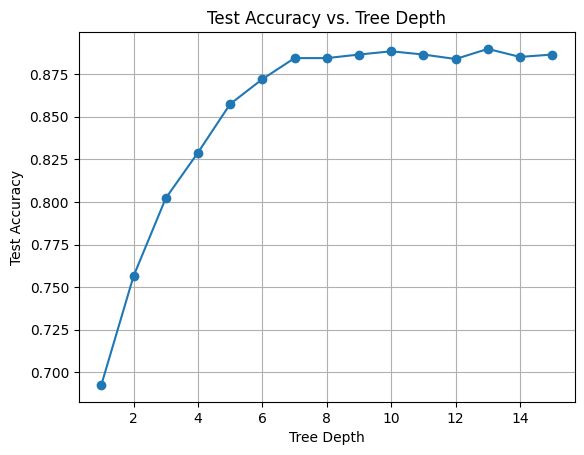

In [ ]:
df = pd.read_csv('./Q1Data.csv')
X = df.iloc[:, :6].to_numpy()  # First 6 MFCC features

# Encode Genus labels into integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Genus'].values)  # Encoded Genus label

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

# Train model and plot accuracies for different depths
depths = range(1, 16)
dt_accuracies_scratch = []
for depth in depths:
    model = DecisionTree(max_depth=depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    dt_accuracies_scratch.append(np.sum(y_pred == y_test) / len(y_test))

plt.plot(depths, dt_accuracies_scratch, marker='o')
plt.title('Test Accuracy vs. Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()

### C). What are your observations from the graph plotted above.



- The decision tree model demonstrates a sharp increase in test accuracy as the depth increases from 1 to 4. This suggests that minimal depth is insufficient for the model to capture the complexity of the data, and adding more layers (depth) allows the model to learn better and improve its predictive accuracy.

- Beyond a depth of 4, the rate of accuracy improvement significantly slows down. While deeper trees continue to model the data with more specificity, the benefits of additional depth in terms of test accuracy begin to diminish.

- Around a depth of 7, the test accuracy levels off, indicating a plateau effect. This implies that adding further depth does not contribute to better generalization by the model on the unseen test data. The model's ability to improve its predictions stabilizes, and additional complexity does not equate to better performance.

- The plateau in accuracy at greater depths raises the possibility of overfitting, where the model may start to learn the noise and specific details of the training data rather than the underlying patterns. Overfitting typically leads to poor generalization to new, unseen data.

- The optimal tree depth appears to be around 6 to 7, as this is where the increase in accuracy plateaus. Choosing this depth may provide a balance between underfitting and overfitting, allowing the model to generalize well without unnecessary complexity.

- Given the observed plateau in test accuracy, pruning the decision tree to maintain a depth around 6 to 7 could be beneficial. This would simplify the model and potentially improve its performance on unseen data by reducing the risk of overfitting.


## Part 2 : k Nearest Neighbours

### A)  Write  a  code  from  scratch  which  predicts  the  Genus  using  the  kNN classifier using all the 21 features.


In [ ]:
def euclidean_distance(row1, row2):
    return np.sqrt(np.sum((row1 - row2) ** 2))

class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return np.array(predictions)

    def _predict(self, x):
        # Compute distances between x and all examples in the training set
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        # Sort by distance and return indices of the first k neighbors
        k_indices = np.argsort(distances)[:self.k]
        # Extract the labels of the k nearest neighbor training samples
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        # Return the most common class label
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]


#### B)   Extract 30 % of the dataset for the reference/training dataset  and  10%  as  test  dataset.  You  do  not  require  to  use  the  entire dataset  for  this  question.  Plot  the  test  accuracy  for  k  ranging from 1,2.....,50

In [ ]:
X = df.iloc[:, :21].to_numpy()  # All 21 MFCC features
y = df['Genus'].to_numpy()       # Genus label

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the kNN classifier
k = 3  # Number of neighbors
knn = KNN(k=k)
knn.fit(X_train, y_train)

# Predict on test set
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = np.sum(y_pred == y_test) / len(y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 98.75%


100%|██████████| 50/50 [59:23<00:00, 71.27s/it]


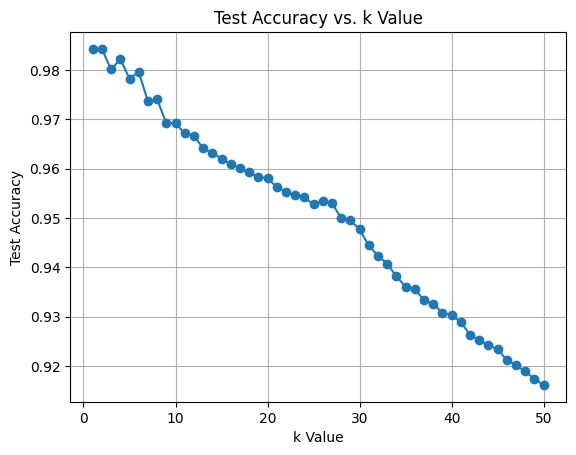

In [ ]:
train_size = 0.3
test_size = 0.1
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, random_state=42)
X_test, _, y_test, _ = train_test_split(X_temp, y_temp, test_size=test_size/(1 - train_size), random_state=42)

k_values = range(1, 51)
knn_accuracies_scratch = []
for k in tqdm(k_values):
    knn = KNN(k=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = np.sum(y_pred == y_test) / len(y_test)
    knn_accuracies_scratch.append(accuracy)

# Plotting the results
plt.plot(k_values, knn_accuracies_scratch, marker='o')
plt.title('Test Accuracy vs. k Value')
plt.xlabel('k Value')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()


100%|██████████| 50/50 [1:40:20<00:00, 120.41s/it]


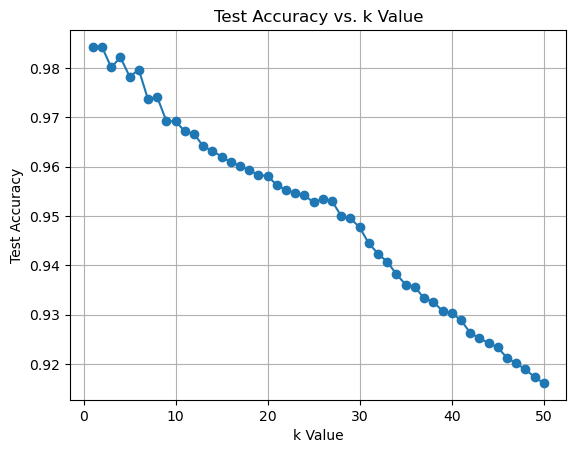

In [ ]:
train_size = 0.3
test_size = 0.1
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, random_state=42)
X_test, _, y_test, _ = train_test_split(X_temp, y_temp, test_size=test_size/(1 - train_size), random_state=42)

k_values = range(1, 51)
knn_accuracies_scratch = []
for k in tqdm(k_values):
    knn = KNN(k=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = np.sum(y_pred == y_test) / len(y_test)
    knn_accuracies_scratch.append(accuracy)

# Plotting the results
plt.plot(k_values, knn_accuracies_scratch, marker='o')
plt.title('Test Accuracy vs. k Value')
plt.xlabel('k Value')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()


### C) Report your observations from the above graph

## Analysis of Test Accuracy vs. k Value for k-Nearest Neighbors Classifier

The graph presents a trend analysis of test accuracy as a function of the k value in a k-Nearest Neighbors (kNN) classifier using a dataset with 21 features.

- **Initial High Accuracy**: There is an observed high test accuracy for lower values of k, particularly when k ranges from 1 to 5. This indicates that the nearest neighbors contribute significantly to the predictive accuracy for the Genus classification.

- **Accuracy Decline with Larger k**: As k increases beyond 5, a gradual decrease in test accuracy is noted. The trend suggests that the inclusion of more distant neighbors potentially introduces noise into the prediction, reducing the classifier's accuracy.

- **Accuracy Stabilization and Subsequent Decline**: Between a k value of approximately 20 and 30, the decrease in accuracy tends to level off, suggesting a region of stability. However, this is followed by a more pronounced decline in test accuracy as k continues to increase, especially noticeable after k surpasses 30.

- **Low Accuracy at High k Values**: The graph indicates the lowest test accuracy occurs at the highest values of k (40 to 50). This part of the trend suggests that considering a larger number of neighbors leads to a prediction that is less representative of the true classification, likely due to the inclusion of less relevant instances from the training set.

In conclusion, the classifier demonstrates optimal performance at a lower range of k values, where the test accuracy is maximized. This analysis underscores the importance of selecting an appropriate k value to balance the classifier's sensitivity to training data against the risk of incorporating misleading information from less similar instances. The determination of the exact optimal k value requires consideration of the highest accuracy achieved and the avoidance of overfitting.


# Part 3 : Using Scikit-Learn functions

## A.)  Now use the inbuilt functions of sklearn library for both Decision Trees and k Nearest Neighbours

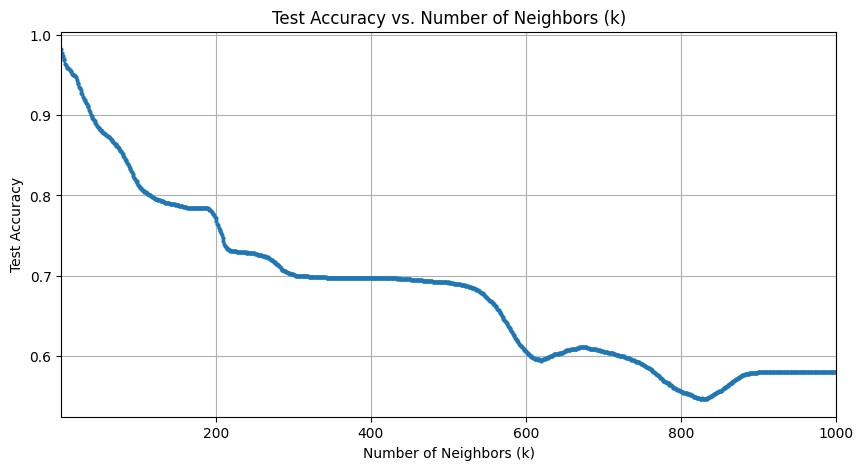

In [ ]:


''' The following code loads the dataset, prepares the data by extracting features and labels,
performs a train-test split, trains a k-Nearest Neighbors classifier for a range of k values,
evaluates the accuracy of each model on the test set, and plots the results. '''

y = df['Genus']
X = df.drop(['Genus', 'Family', 'Species'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

k_values = np.arange(1, 1001)

accuracies = np.array([
    KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train).score(X_test, y_test)
    for k in k_values
])

plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracies, marker='o', linestyle='-', markersize=2)
plt.title('Test Accuracy vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.xlim(1, 1000)
plt.show()


### B.)  Here you need to use all the features and entire dataset.

#### i. For  Decision  Tree  :  Train  Test  ratio  is  80:20  and  depth varies from 1,...15
#### ii. For  kNN  :  Train  Test  ratio  is  80:20  and  k  varies  from 1,....,1000.

In [10]:
y = df['Genus']
X = df.drop(['Genus', 'Family', 'Species'], axis=1)

X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X, y, test_size=0.2, random_state=42)

dt_depths = range(1, 16)
dt_accuracies = []
for depth in dt_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_clf.fit(X_train_dt, y_train_dt)
    y_pred_dt = dt_clf.predict(X_test_dt)
    dt_accuracies.append(accuracy_score(y_test_dt, y_pred_dt))



### C).  Plot the test accuracies as you have done in Part 1 and 2.


Accuracy score for Decision Tree: [0.7394023627519111, 0.7963863794301599, 0.8387769284225156, 0.8728283530229326, 0.8728283530229326, 0.9027102154273802, 0.9374565670604587, 0.9416261292564281, 0.9478804725503822, 0.9527449617790132, 0.9569145239749827, 0.9541348158443363, 0.9555246699096595, 0.9583043780403058, 0.9583043780403058]


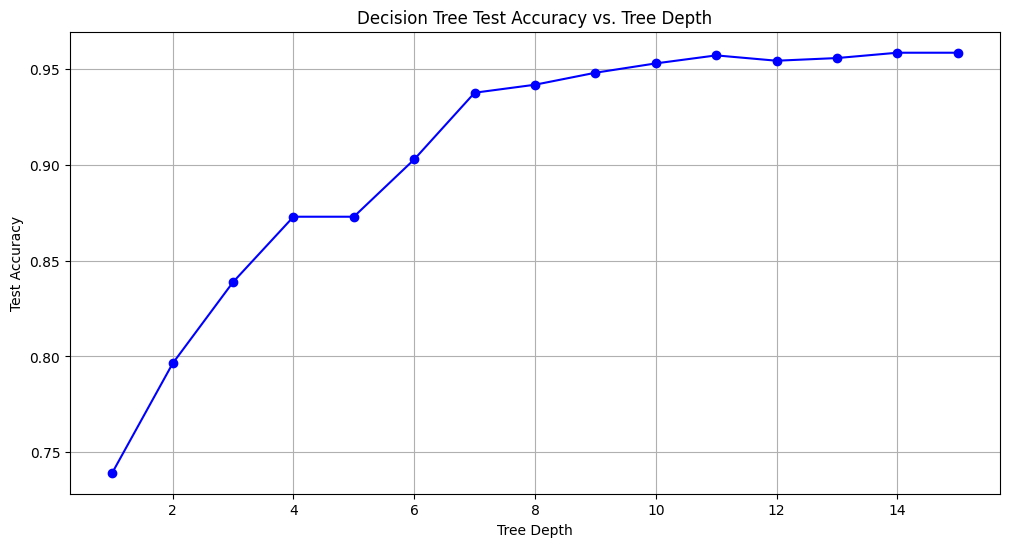

In [11]:

print(f'Accuracy score for Decision Tree: {dt_accuracies}')

plt.figure(figsize=(12, 6))
plt.plot(dt_depths, dt_accuracies, marker='o', linestyle='-', color='blue')
plt.title('Decision Tree Test Accuracy vs. Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()

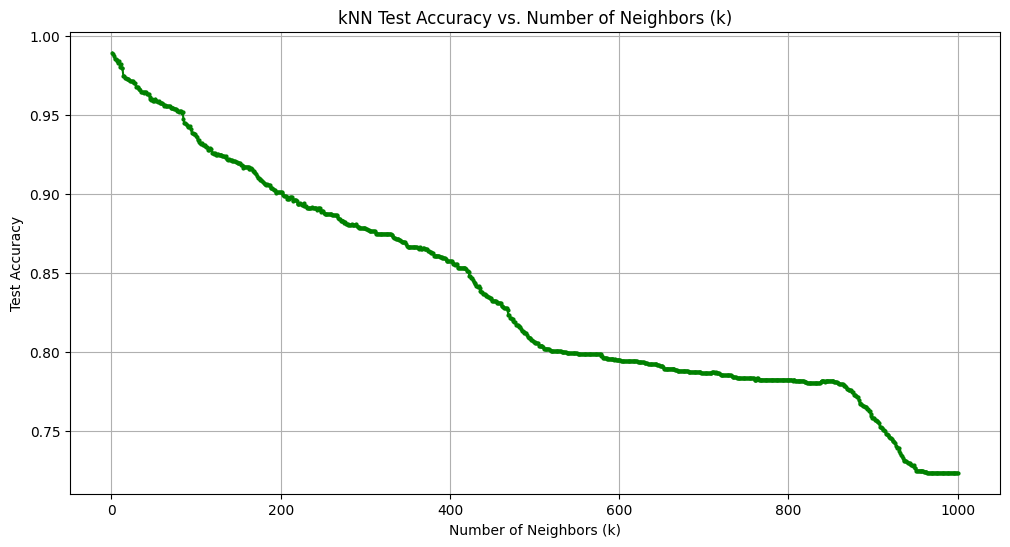

In [12]:

k_values = range(1, 1001)
knn_accuracies = []
for k in k_values:
    knn_clf = KNeighborsClassifier(n_neighbors=k)
    knn_clf.fit(X_train_knn, y_train_knn)
    y_pred_knn = knn_clf.predict(X_test_knn)
    knn_accuracies.append(accuracy_score(y_test_knn, y_pred_knn))

plt.figure(figsize=(12, 6))
plt.plot(k_values, knn_accuracies, marker='o', linestyle='-', color='green', markersize=2)
plt.title('kNN Test Accuracy vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()


### D). Plot all 4 graphs together on a subplot and report your observations comparing the accuracy of model built from Scratch and inbuilt function for both the classifiers.

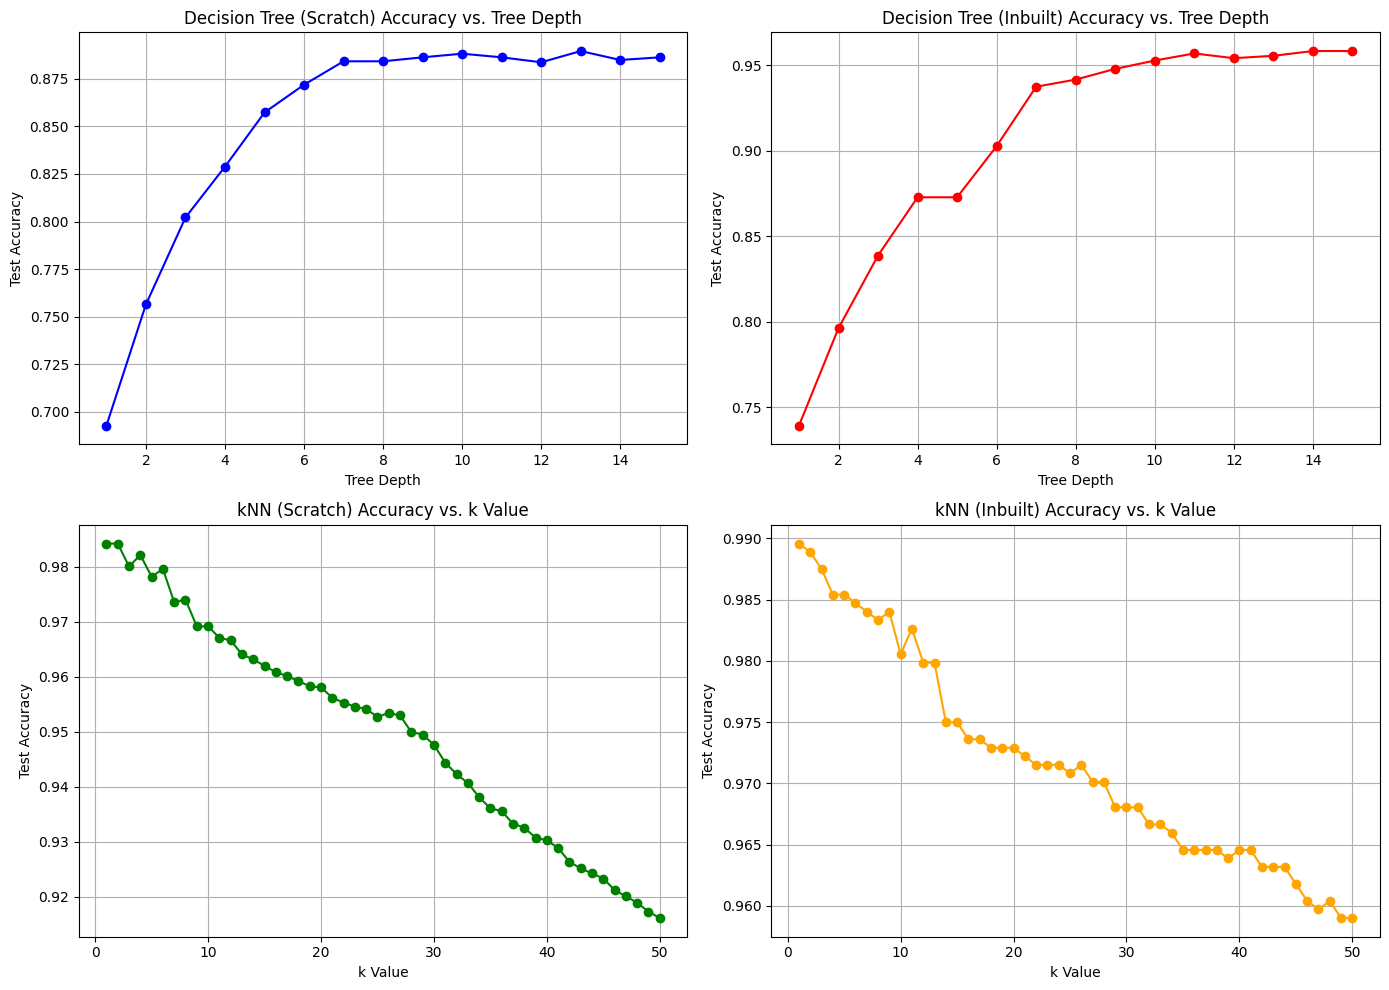

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

axes[0, 0].plot(dt_depths, dt_accuracies_scratch, marker='o', linestyle='-', color='blue')
axes[0, 0].set_title('Decision Tree (Scratch) Accuracy vs. Tree Depth')
axes[0, 0].set_xlabel('Tree Depth')
axes[0, 0].set_ylabel('Test Accuracy')
axes[0, 0].grid(True)

axes[0, 1].plot(dt_depths, dt_accuracies, marker='o', linestyle='-', color='red')
axes[0, 1].set_title('Decision Tree (Inbuilt) Accuracy vs. Tree Depth')
axes[0, 1].set_xlabel('Tree Depth')
axes[0, 1].set_ylabel('Test Accuracy')
axes[0, 1].grid(True)

axes[1, 0].plot(k_values[:50], knn_accuracies_scratch[:50], marker='o', linestyle='-', color='green')
axes[1, 0].set_title('kNN (Scratch) Accuracy vs. k Value')
axes[1, 0].set_xlabel('k Value')
axes[1, 0].set_ylabel('Test Accuracy')
axes[1, 0].grid(True)

axes[1, 1].plot(k_values[:50], knn_accuracies[:50], marker='o', linestyle='-', color='orange')
axes[1, 1].set_title('kNN (Inbuilt) Accuracy vs. k Value')
axes[1, 1].set_xlabel('k Value')
axes[1, 1].set_ylabel('Test Accuracy')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()
